In [1]:
SCHEME = 'duped'

# Loading dataset

In [2]:
from datasets import load_dataset
import pandas as pd
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
tqdm.pandas()

In [3]:
dataset = load_dataset(f"usvsnsp/{SCHEME}-num-duplicates", cache_dir = '/fsx/orz/temp')

Found cached dataset parquet (/fsx/orz/temp/usvsnsp___parquet/usvsnsp--duped-num-duplicates-a3960da60a581d19/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/1 [00:00<?, ?it/s]

In [4]:
dataset = dataset['train'].to_pandas()

In [5]:
dataset

,Index,Counts
0,0,1
1,1,2
2,2,2
3,3,1
4,4,1
...,...,...
146431995,146431995,2
146431996,146431996,4
146431997,146431997,2
146431998,146431998,2


# Loading memorized evals

In [6]:
model = '12B'
root_dir = '/fsx/orz/memorization-evals/evals_32/'

if SCHEME == 'duped':
    path = root_dir + f'memorization_{model}_143000.hdf'
else:
    path = root_dir + f'memorization_{model}-deduped_143000.hdf'

In [7]:
memorization_evals = pd.read_hdf(path, key = 'memorization').sort_values("index")

In [8]:
dataset['memorization_score'] = memorization_evals['accuracy'].to_numpy()

# Remove duplicates

In [9]:
if SCHEME == 'duped':
    path = 'results/standard_unique_indicies.pkl'
else:
    path = 'results/deduped_unique_indicies.pkl'

In [10]:
import pickle
with open(path, 'rb') as f:
    unique_indicies = set(pickle.load(f))

In [11]:
dataset = dataset[dataset['Index'].progress_map(lambda x:x in unique_indicies)]

  0%|          | 0/146432000 [00:00<?, ?it/s]

# Subset to counts less than a threshold

In [13]:
dataset = dataset[dataset['Counts'] < 600]

# Memorization histogram

Text(0.5, 1.0, 'Full Deduped Distribution')

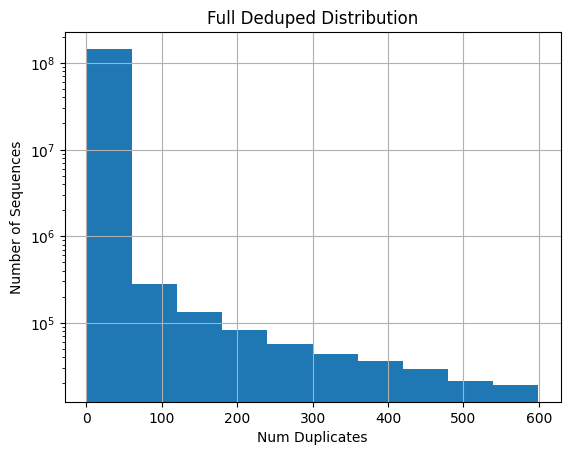

In [20]:
ax = dataset['Counts'].hist()
ax.set_yscale('log')
ax.set_xlabel("Num Duplicates")
ax.set_ylabel("Number of Sequences")
ax.set_title(f"Full {SCHEME.capitalize()} Distribution")

Text(0.5, 1.0, 'Deduped Memorized Distribution, Predicting Pythia-12B')

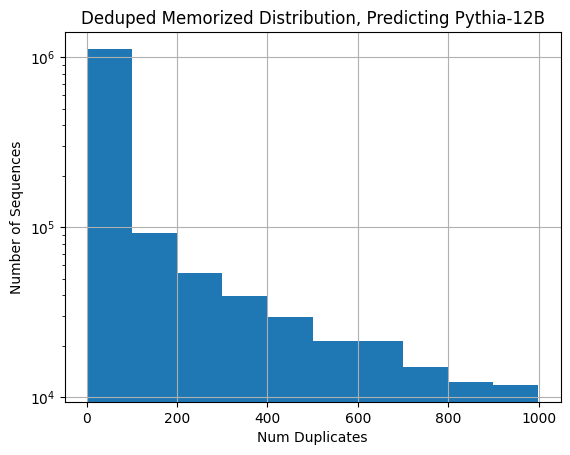

In [14]:
ax = dataset[dataset['memorization_score'] == 1]['Counts'].hist()
ax.set_yscale('log')
ax.set_xlabel("Num Duplicates")
ax.set_ylabel("Number of Sequences")
ax.set_title(f"{SCHEME.capitalize()} Memorized Distribution, Predicting Pythia-12B")

Text(0.5, 1.0, 'Deduped Non-Memorized Distribution, Predicting Pythia-12B')

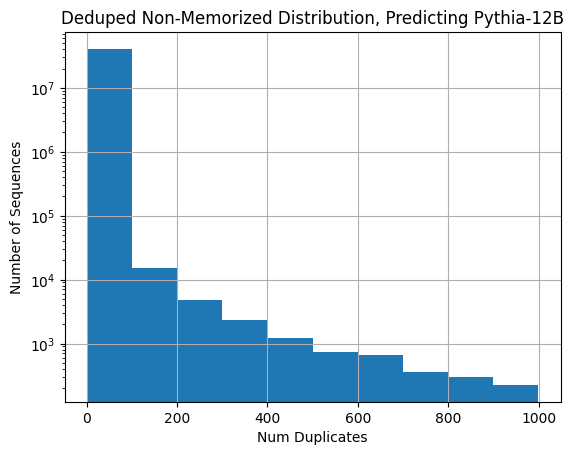

In [15]:
ax = dataset[dataset['memorization_score'] == 0]['Counts'].hist()
ax.set_yscale('log')
ax.set_xlabel("Num Duplicates")
ax.set_ylabel("Number of Sequences")
ax.set_title(f"{SCHEME.capitalize()} Non-Memorized Distribution, Predicting Pythia-12B")

In [14]:
dataset['is_memorized'] = dataset['memorization_score'] == 1

In [15]:
memorized_instances = dataset[dataset['memorization_score'] == 1]['Counts']

non_memorized_instances = dataset[dataset['memorization_score'] != 1]['Counts']

Text(0.5, 1.0, 'Duped Sequence Duplicate Distribution, Predicting Pythia-12B')

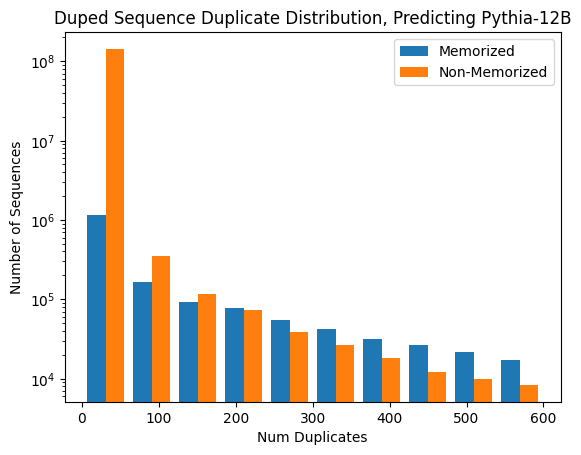

In [16]:
ax = plt.hist(x = [ memorized_instances, non_memorized_instances], log = True, label = ['Memorized', 'Non-Memorized'])
plt.legend()
plt.xlabel("Num Duplicates")
plt.ylabel("Number of Sequences")
plt.title(f"{SCHEME.capitalize()} Sequence Duplicate Distribution, Predicting Pythia-12B")